# Asynchronous Lecture 01

## Model Selection

### CIS432 Machine Learning for Business Analytics


In [ ]:
# Load dataset
import pandas as pd
fico_data_url = 'https://drive.google.com/uc?id=1-VDv1gnQSVW0IeepWw1N0yPb-p5bjJY9&export=download'
df_fico = pd.read_csv(fico_data_url)
df_fico.head(3)

,ExternalRiskEstimate,MSinceOldestTradeOpen,MSinceMostRecentTradeOpen,AverageMInFile,NumSatisfactoryTrades,NumTrades60Ever2DerogPubRec,NumTrades90Ever2DerogPubRec,PercentTradesNeverDelq,MSinceMostRecentDelq,MaxDelq2PublicRecLast12M,...,MSinceMostRecentInqexcl7days,NumInqLast6M,NumInqLast6Mexcl7days,NetFractionRevolvingBurden,NetFractionInstallBurden,NumRevolvingTradesWBalance,NumInstallTradesWBalance,NumBank2NatlTradesWHighUtilization,PercentTradesWBalance,RiskPerformance
0,55,144,4,84,20,3,0,83,2,3,...,0,0,0,33,-8,8,1,1,69,Bad
1,61,58,15,41,2,4,4,100,-7,0,...,0,0,0,0,-8,0,-8,-8,0,Bad
2,67,66,5,24,9,0,0,100,-7,7,...,0,4,4,53,66,4,2,1,86,Bad


In [ ]:
# Split to in-sample and out-of-sample (test) data
from sklearn.model_selection import train_test_split
X = df_fico.iloc[:,:-1]
Y = (df_fico.iloc[:,-1]=='Bad').astype(int)
X_in_sample, X_out_of_sample, Y_in_sample, Y_out_of_sample = train_test_split(X, Y, test_size=0.2, random_state=1234)
Y_in_sample = Y_in_sample[X_in_sample['ExternalRiskEstimate']!=-9]
X_in_sample = X_in_sample[X_in_sample['ExternalRiskEstimate']!=-9]
Y_out_of_sample = Y_out_of_sample[X_out_of_sample['ExternalRiskEstimate']!=-9]
X_out_of_sample = X_out_of_sample[X_out_of_sample['ExternalRiskEstimate']!=-9]
print(f"Complete dataset:{X.shape}\nIn-sample dataset:{X_in_sample.shape}\nOut-of-sample dataset {X_out_of_sample.shape}")

Complete dataset:(9871, 23)
In-sample dataset:(7888, 23)
Out-of-sample dataset (1973, 23)


## The validation set approach

In [ ]:
# Evaluation using simple cross-validation / the validation set approach 60:20:20
X_test, Y_test = X_out_of_sample, Y_out_of_sample
X_train, X_validation, Y_train, Y_validation = train_test_split(X_in_sample, Y_in_sample, test_size=0.25, random_state=1234)
print(f"Complete dataset:{X.shape}\nTrain dataset:{X_train.shape}\nValidation dataset:{X_validation.shape}\nTest dataset {X_test.shape}")

Complete dataset:(9871, 23)
Train dataset:(5916, 23)
Validation dataset:(1972, 23)
Test dataset (1973, 23)


In [ ]:
# Train models using the train data and evaluate them on the validation data
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import *
models = []
for d in range(1,21):
  clf_tree = DecisionTreeClassifier(max_depth=d, random_state=0).fit(X_train, Y_train)
  train_acc = accuracy_score(Y_train, clf_tree.predict(X_train))
  validation_acc = accuracy_score(Y_validation, clf_tree.predict(X_validation))
  models.append({"Depth":d, "Train accuracy":train_acc, "Validation accuracy":validation_acc})
print(f"Finished training {len(models)} models")

Finished training 20 models


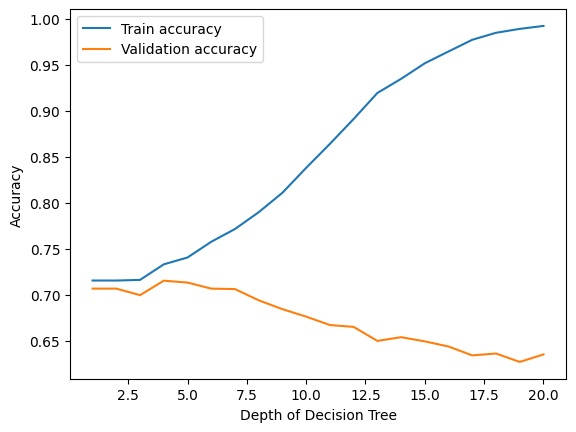

In [ ]:
# Visualize results
import matplotlib.pyplot as plt
df_models = pd.DataFrame(models)
df_models.iloc[:,:-1]
plt.plot(df_models["Depth"], df_models["Train accuracy"], label = "Train accuracy")
plt.plot(df_models["Depth"], df_models["Validation accuracy"], label = "Validation accuracy")
plt.xlabel("Depth of Decision Tree")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
# Retrieve the best model
best_model = df_models.loc[df_models['Validation accuracy'].idxmax()].to_dict()
best_model

{'Depth': 4.0,
 'Train accuracy': 0.7332657200811359,
 'Validation accuracy': 0.7155172413793104}

In [ ]:
# Retrain a model on the entire in-sample data (train+validation)
clf_tree = DecisionTreeClassifier(max_depth=int(best_model['Depth']), random_state=0).fit(X_in_sample, Y_in_sample)
train_acc = accuracy_score(Y_in_sample, clf_tree.predict(X_in_sample))
test_acc = accuracy_score(Y_test, clf_tree.predict(X_test))
print(f"Train accuracy: {train_acc:.3f}")
print(f"Test accuracy: {test_acc:.3f}")

Train accuracy: 0.731
Test accuracy: 0.701


## Cross validation (CV)

In [ ]:
# Initialize train and test sets
X_train, Y_train = X_in_sample, Y_in_sample
X_test, Y_test = X_out_of_sample, Y_out_of_sample

In [ ]:
# Evaluate models using K-folds cross validation
from sklearn.model_selection import cross_val_score
K=5
models = []
for d in range(1,21):
  clf_tree = DecisionTreeClassifier(max_depth=d, random_state=0)
  scores = cross_val_score(clf_tree, X_train, Y_train, cv=K)
  models.append({"Depth":d, "Train accuracy":train_acc, f"{K}-fold CV (mean)":scores.mean(), f"{K}-fold CV (all)":scores})
print(f"Finished training {len(models)*K} models")

Finished training 100 models


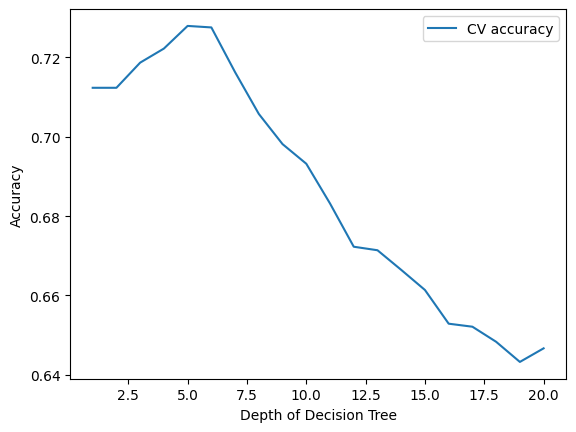

In [ ]:
# Visualize results
import matplotlib.pyplot as plt
df_models = pd.DataFrame(models)
df_models.iloc[:,:-1]
plt.plot(df_models["Depth"], df_models[f"{K}-fold CV (mean)"], label = "CV accuracy")
plt.xlabel("Depth of Decision Tree")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
# Retrieve the best model
best_model = df_models.loc[df_models[f"{K}-fold CV (mean)"].idxmax()]
best_model

,4
Depth,5
Train accuracy,0.731364
5-fold CV (mean),0.727941
5-fold CV (all),"[0.7414448669201521, 0.7173637515842839, 0.729..."


In [ ]:
# Retrain a model on the entire in-sample data (train+validation)
clf_tree = DecisionTreeClassifier(max_depth=best_model['Depth'], random_state=0).fit(X_in_sample, Y_in_sample)
train_acc = accuracy_score(Y_in_sample, clf_tree.predict(X_in_sample))
test_acc = accuracy_score(Y_test, clf_tree.predict(X_test))
print(f"Train accuracy: {train_acc:.3f}")
print(f"Test accuracy: {test_acc:.3f}")

Train accuracy: 0.740
Test accuracy: 0.696


## Performance metrics

scikit-learn contains implementation of the most common metrics for classification and regression

https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

In [ ]:
# Example: compute the F1-score using the test set
f1_score(clf_tree.predict(X_test), Y_test)

0.7067448680351907

In [ ]:
# Example: run cross validation with an alternative evaluation metric
cross_val_score(clf_tree, X_train, Y_train, cv=K) # accuracy by default

array([0.74144487, 0.71736375, 0.72940431, 0.72733037, 0.7241598 ])

In [ ]:
cross_val_score(clf_tree, X_train, Y_train, cv=K, scoring='accuracy') # accuracy, stated explicitly

array([0.74144487, 0.71736375, 0.72940431, 0.72733037, 0.7241598 ])

In [ ]:
cross_val_score(clf_tree, X_train, Y_train, cv=K, scoring='recall') # recall

array([0.76735688, 0.73780488, 0.74390244, 0.74268293, 0.75609756])

## Confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(Y_test, clf_tree.predict(X_test))

array([[650, 296],
       [304, 723]])

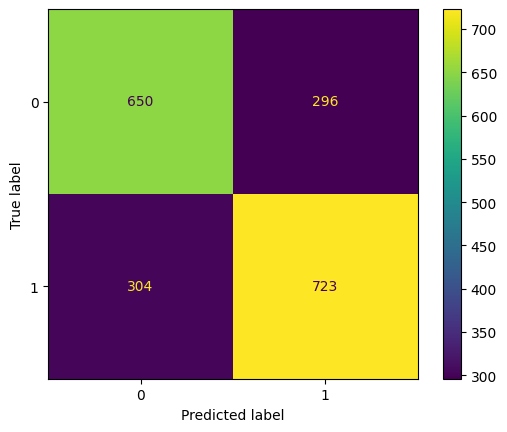

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(clf_tree, X_test, Y_test);

## ROC curve

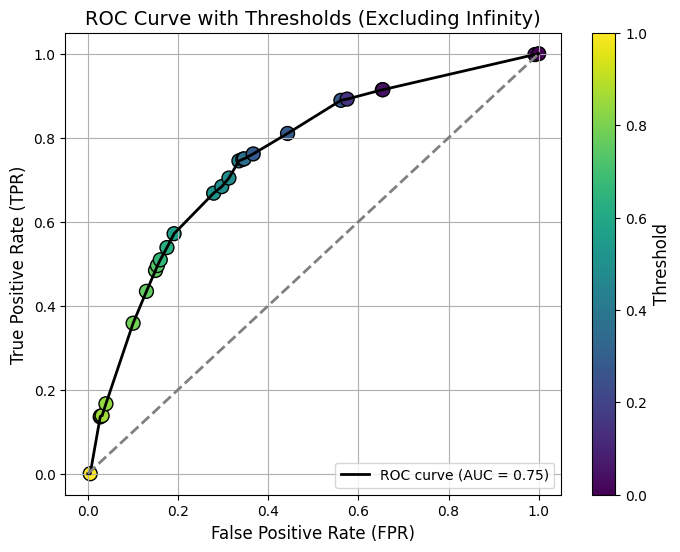

In [ ]:
from sklearn.metrics import roc_curve, auc
import numpy as np


# Example data: predicted probabilities and true labels
y_proba = clf_tree.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
fpr, tpr, thresholds = roc_curve(Y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Exclude infinite thresholds
finite_thresholds = thresholds[np.isfinite(thresholds)]
finite_fpr = fpr[np.isfinite(thresholds)]
finite_tpr = tpr[np.isfinite(thresholds)]

# Normalize thresholds for coloring
norm_thresholds = (finite_thresholds - finite_thresholds.min()) / (finite_thresholds.max() - finite_thresholds.min())

# Plot ROC curve
plt.figure(figsize=(8, 6))
points = plt.scatter(finite_fpr, finite_tpr, c=norm_thresholds, cmap='viridis', edgecolor='k', s=100)
plt.plot(fpr, tpr, color='black', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)  # Diagonal line

# Add colorbar to indicate thresholds
cbar = plt.colorbar(points)
cbar.set_label('Threshold', fontsize=12)

# Add labels, title, and legend
plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
plt.title('ROC Curve with Thresholds (Excluding Infinity)', fontsize=14)
plt.legend(loc="lower right")
plt.grid()
plt.show()

We can perform post hoc tuning and adjust the existing model to work with a different threshold to achieve a better FPR-TPR balance.

(1) Manually - we predict by comparing clf_tree.predict_proba() with the new threshold (instead of the default 0.5)

In [ ]:
y_proba = clf_tree.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class
custom_threshold = 0.7 # predict more zeros
y_pred = (y_proba >= custom_threshold).astype(int)

# Confusion matrix for the original model
print('Original confusion matrix\n', confusion_matrix(Y_test, clf_tree.predict(X_test)))

# Confusion matrix for the post-hoc-tuned model
print('\nConfusion matrix of the post-hoc tuned model\n', confusion_matrix(Y_test, y_pred))

Original confusion matrix
 [[650 296]
 [304 723]]

Confusion matrix of the post-hoc tuned model
 [[794 152]
 [504 523]]


(2) Creating a wrapper around

In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin

class ThresholdClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, base_model, threshold=0.5):
        self.base_model = base_model
        self.threshold = threshold

    def fit(self, X, y):
        self.base_model.fit(X, y)
        return self

    def predict_proba(self, X):
        return self.base_model.predict_proba(X)

    def predict(self, X):
        # Modify predictions based on the custom threshold
        proba = self.predict_proba(X)[:, 1]  # Probabilities for the positive class
        return (proba >= self.threshold).astype(int)


# Create custom model with threshold
custom_model = ThresholdClassifier(clf_tree, threshold=0.7)
custom_model.fit(X_in_sample, Y_in_sample)

confusion_matrix(Y_test, custom_model.predict(X_test))

array([[794, 152],
       [504, 523]])

### Hyper-parameter tuning

#### Grid Search

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = [{'criterion':["gini", "entropy"],'max_depth':[1,2,3,4,5,6,7,8]}]
clf_tree = DecisionTreeClassifier(random_state=0)
grid_search = GridSearchCV(clf_tree, param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train, Y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=0),
             param_grid=[{'criterion': ['gini', 'entropy'],
                          'max_depth': [1, 2, 3, 4, 5, 6, 7, 8]}],
             scoring='accuracy')

In [ ]:
print(f"Number of configurations: {2*8}, number of models trained: {2*8*3 + 1}")

Number of configurations: 16, number of models trained: 49


In [ ]:
cvres = grid_search.cv_results_ # the variable that stores the grid search results
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):  # iterate over the tested configurations
    print(mean_score, params)

0.7122206200606379 {'criterion': 'gini', 'max_depth': 1}
0.7122206200606379 {'criterion': 'gini', 'max_depth': 2}
0.7145020853008827 {'criterion': 'gini', 'max_depth': 3}
0.7190670887888381 {'criterion': 'gini', 'max_depth': 4}
0.7143751497506847 {'criterion': 'gini', 'max_depth': 5}
0.7131084457698836 {'criterion': 'gini', 'max_depth': 6}
0.7025861491283004 {'criterion': 'gini', 'max_depth': 7}
0.6970085055978433 {'criterion': 'gini', 'max_depth': 8}
0.7122206200606379 {'criterion': 'entropy', 'max_depth': 1}
0.7122206200606379 {'criterion': 'entropy', 'max_depth': 2}
0.7137416290271182 {'criterion': 'entropy', 'max_depth': 3}
0.7204615960904043 {'criterion': 'entropy', 'max_depth': 4}
0.7131082047225038 {'criterion': 'entropy', 'max_depth': 5}
0.7139960304317495 {'criterion': 'entropy', 'max_depth': 6}
0.7065157035136513 {'criterion': 'entropy', 'max_depth': 7}
0.6947258351206997 {'criterion': 'entropy', 'max_depth': 8}


In [ ]:
# Best configuration
grid_search.best_params_

{'criterion': 'entropy', 'max_depth': 4}

In [ ]:
# Best model (fitted on the entire dataset)
grid_search.best_estimator_

DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=0)

In [ ]:
# out-of-sample / test accuracy
test_acc = accuracy_score(Y_test, grid_search.best_estimator_.predict(X_test))
print(f"Test accuracy: {test_acc:.3f}")

Test accuracy: 0.701


#### Randomized search

In [ ]:
# Example for sampling 5 integers between 1 to 10
from scipy.stats import randint
samples = randint.rvs(1, 10, size=5)
samples

array([2, 8, 2, 6, 4])

In [ ]:
# An example for hyper-parameter tuning using RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV
distributions = dict(max_depth=randint(low=1, high=11), criterion=["gini", "entropy"])
clf_tree = DecisionTreeClassifier(random_state=0)
randomized_search = RandomizedSearchCV(clf_tree, distributions, random_state=0, n_iter=7)
randomized_search.fit(X_train, Y_train)

RandomizedSearchCV(estimator=DecisionTreeClassifier(random_state=0), n_iter=7,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fc7a3042590>},
                   random_state=0)

In [ ]:
# explore results
randomized_search.cv_results_['params']

[{'criterion': 'gini', 'max_depth': 6},
 {'criterion': 'gini', 'max_depth': 4},
 {'criterion': 'entropy', 'max_depth': 4},
 {'criterion': 'entropy', 'max_depth': 10},
 {'criterion': 'entropy', 'max_depth': 6},
 {'criterion': 'gini', 'max_depth': 5},
 {'criterion': 'entropy', 'max_depth': 7}]

In [ ]:
# Similar to grid_search
randomized_search.best_params_

{'criterion': 'gini', 'max_depth': 5}